# hw2: Решающие деревья

*Спасибо великому курсу великого Евгения Соколова*

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплементацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

Все данные, на которых будут обучаться модели, вы можете найти на диске.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Неэффективная и/или неоригинальная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Заполненный ноутбук ```hw2-trees.ipynb``` и модуль с реализованными функциями и классами ```hw2code.py``` необходимо загрузить на свой Github. Затем нужно оставить комментарий в Google-таблице с оценками в столбце <<hw2>> в строке со своей фамилией о том, что вы выполнили работу с указанием ника на Kaggle.

In [283]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

from decision_tree import find_best_split, DecisionTree

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from collections import defaultdict

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [284]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0, )
]

In [285]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

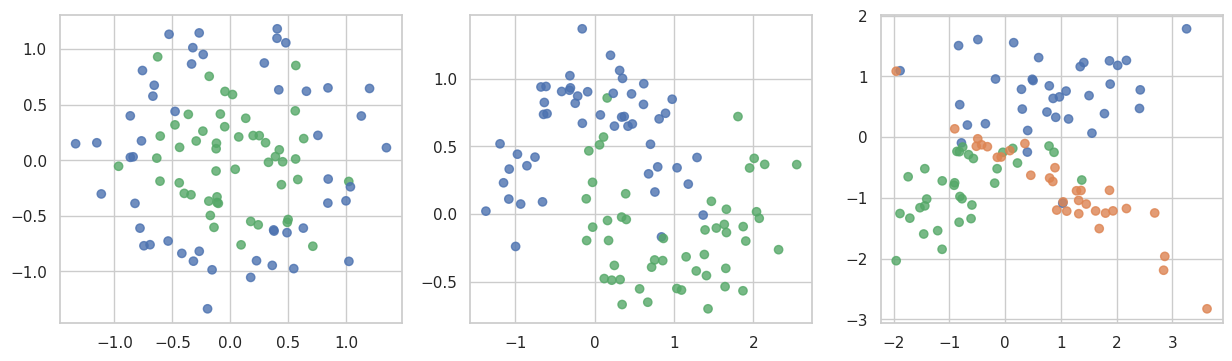

In [286]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [287]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

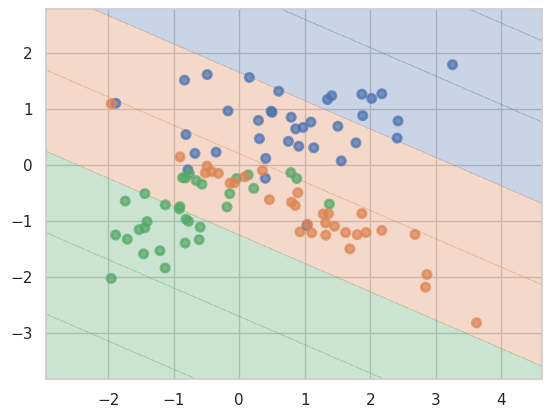

In [288]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

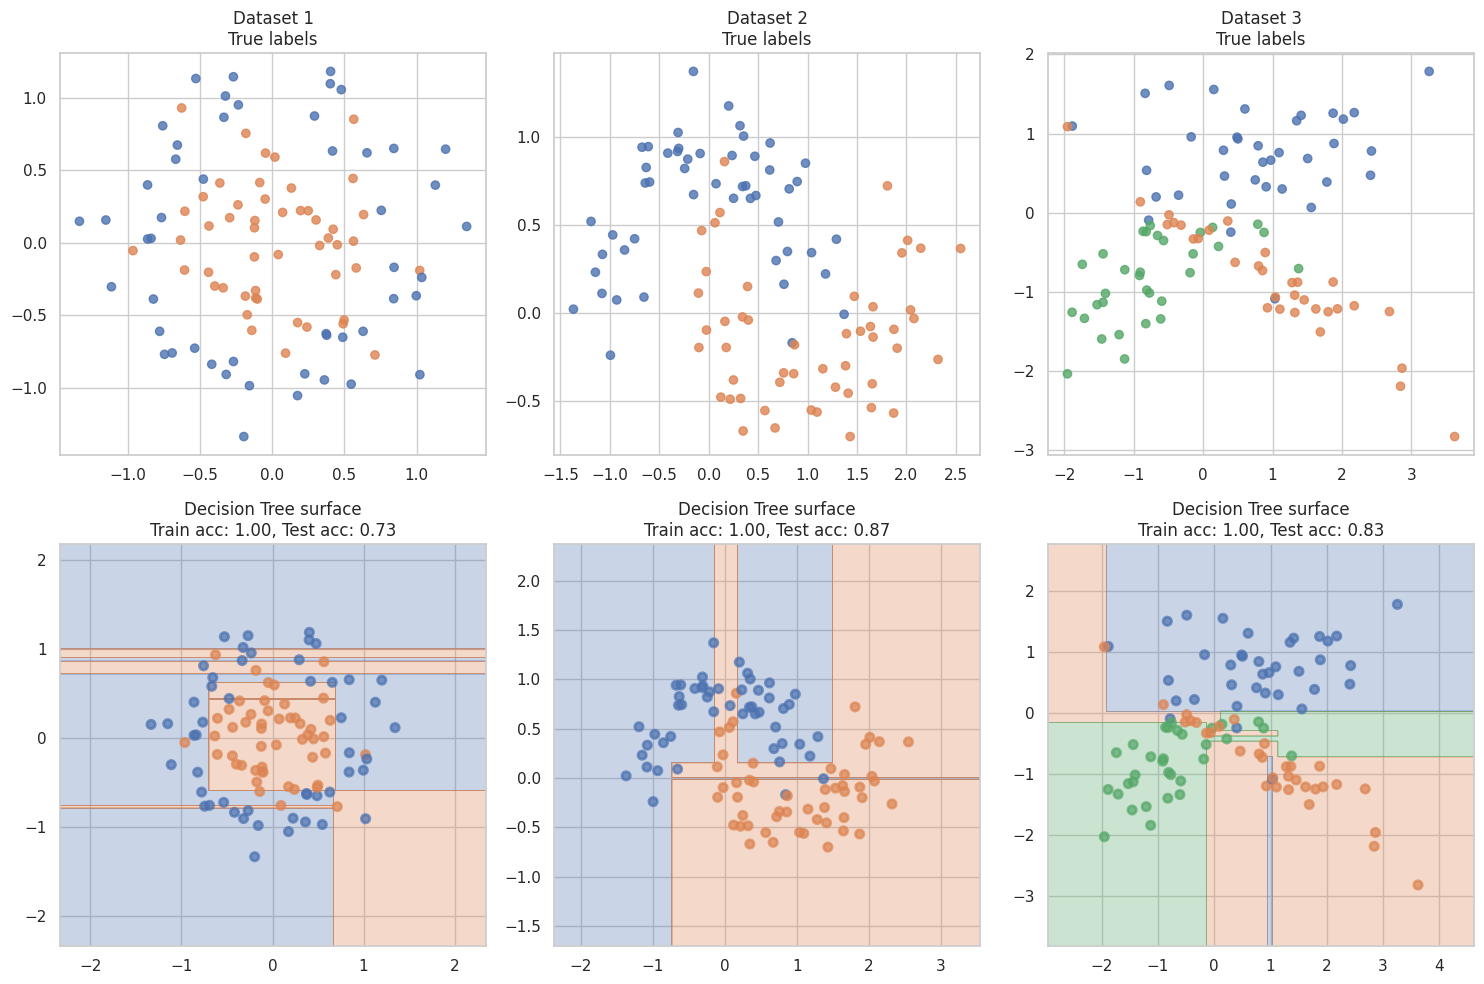

In [289]:
plt.figure(figsize=(15, 10))
for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                        random_state=42)

    tree = DecisionTreeClassifier(random_state=42)
    tree.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, tree.predict(X_train))
    test_acc = accuracy_score(y_test, tree.predict(X_test))

    plt.subplot(2, 3, i + 1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(sns.color_palette(n_colors=len(np.unique(y)))),
                alpha=.8)
    plt.title(f"Dataset {i+1}\nTrue labels")

    plt.subplot(2, 3, i + 4)
    plot_surface(tree, X, y)
    plt.title(f"Decision Tree surface\nTrain acc: {train_acc:.2f}, Test acc: {test_acc:.2f}")

plt.tight_layout()
plt.show()

__Ответ:__

Решающие деревья с параметрами по умолчанию действительно склонны к переобучению. На всех графиках можно заметить, что решающие деревья построили сложные изломанные границы, повторяющие обучающие точки.

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

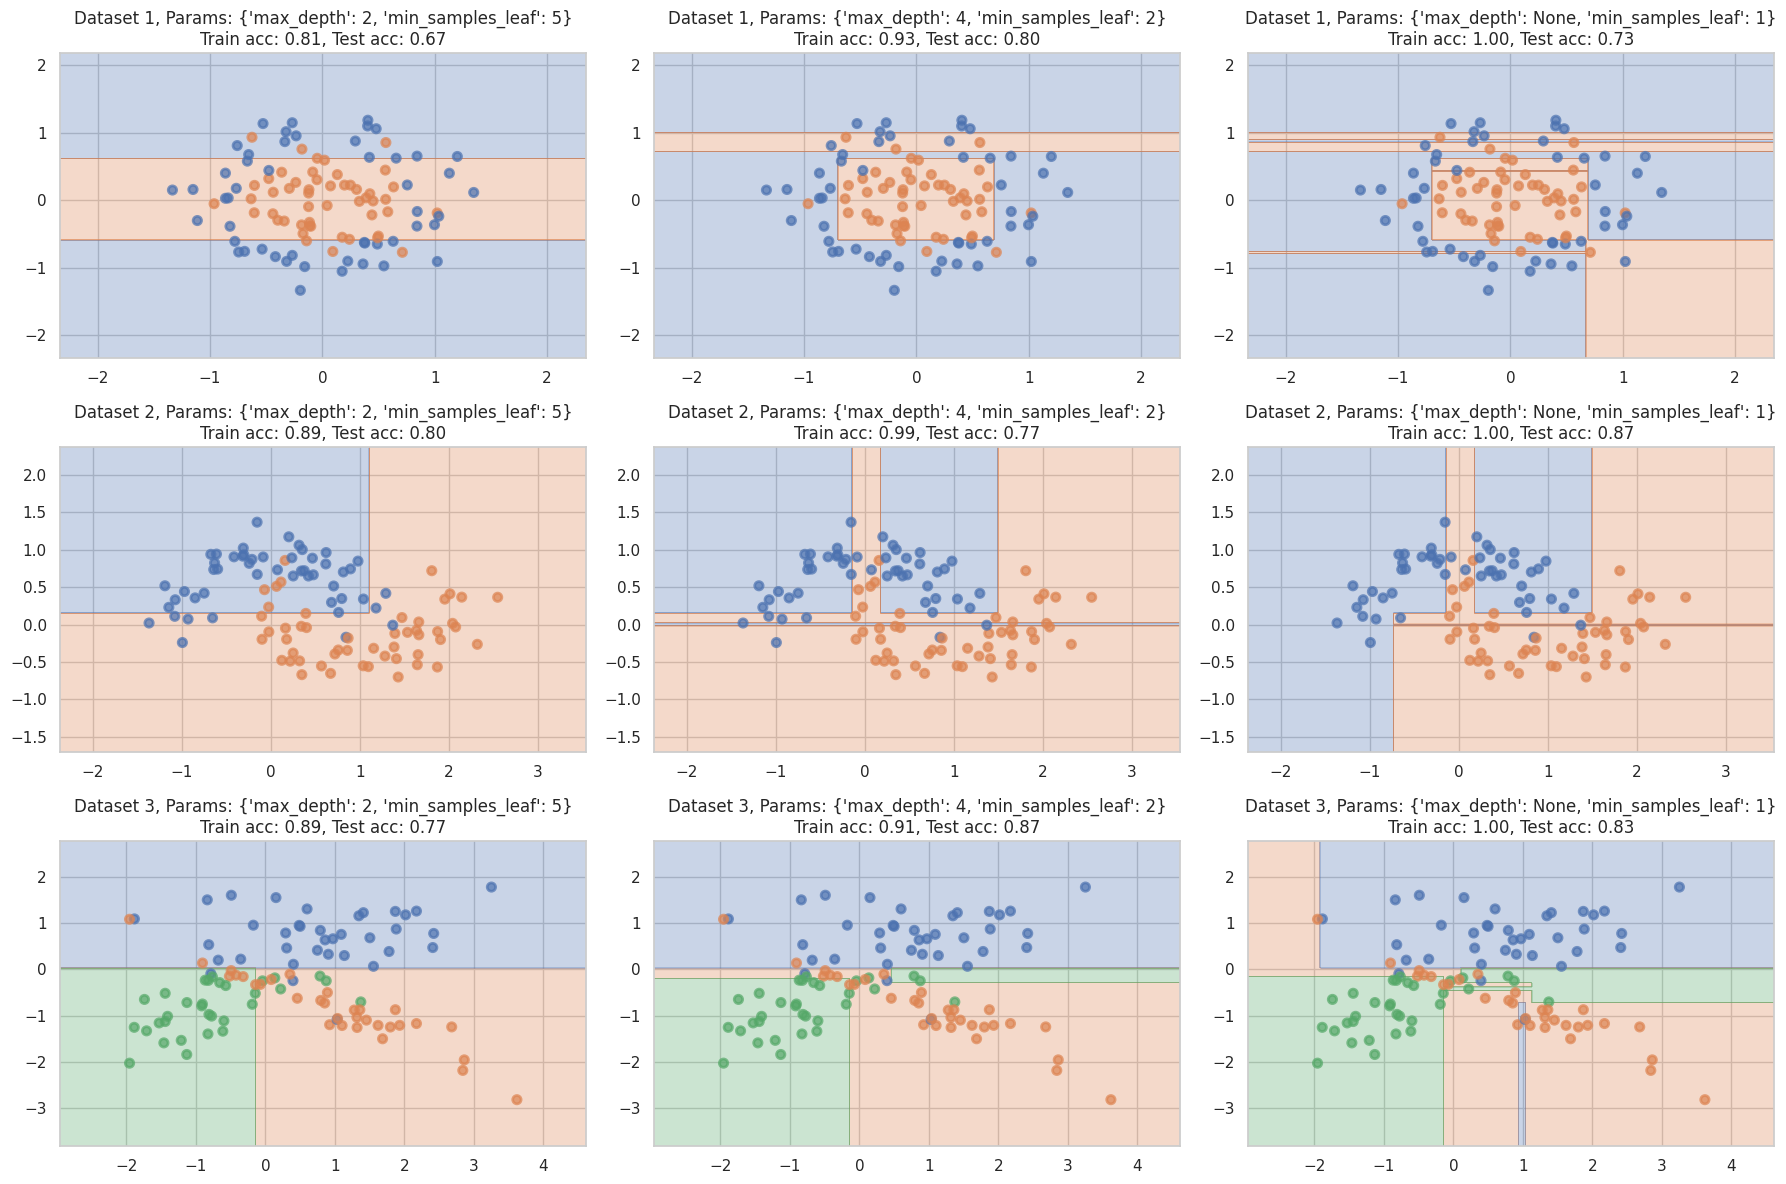

In [290]:
params_grid = [
    {'max_depth': 2, 'min_samples_leaf': 5},
    {'max_depth': 4, 'min_samples_leaf': 2},
    {'max_depth': None, 'min_samples_leaf': 1}
]

plt.figure(figsize=(18, 12))
random_state = 42

for i, (X, y) in enumerate(datasets):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state)

    for j, params in enumerate(params_grid):
        tree = DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=random_state
        )
        tree.fit(X_train, y_train)

        train_acc = accuracy_score(y_train, tree.predict(X_train))
        test_acc = accuracy_score(y_test, tree.predict(X_test))

        plt.subplot(len(datasets), len(params_grid), i*len(params_grid) + j + 1)
        plot_surface(tree, X, y)
        title = f"Dataset {i+1}, Params: {params}\n"
        title += f"Train acc: {train_acc:.2f}, Test acc: {test_acc:.2f}"
        plt.title(title)

plt.tight_layout()
plt.show()

__Ответ:__

Разделяющая поверхность стоновится всё более сложной с увеличением глубины дерева и уменьшением минимального количества элементов в листьях.

Первый датасет(circles) сначала улучших показатель точности на тестовой выборке, но затем точность стала хуже. Это яркий пример переобучения.
Второй датасет(moons) то ухудшил, то улучшил точность. Третий датасет(classification) сначала улучшил точность, а затем немного ухудишл.

Усложнение модели ведёт к переобучению. Это лучше заметно на сложно разделяемых датасетах.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw2code.py

__Задание 4. (0.5 балла)__

Загрузите таблицу students.csv (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

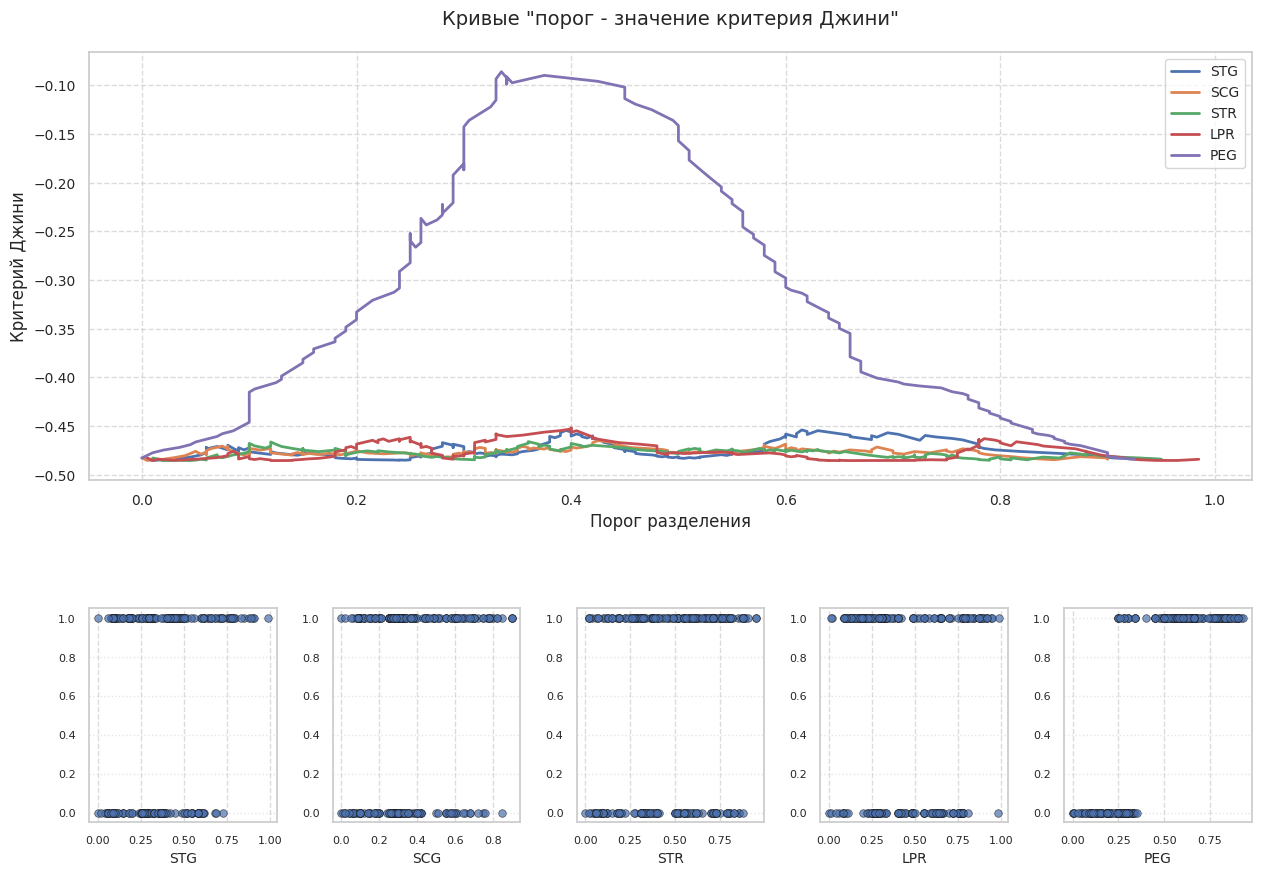

In [291]:
data = pd.read_csv('students.csv')

features = data[['STG', 'SCG', 'STR', 'LPR', 'PEG']].values
target = data['UNS'].values

if isinstance(target[0], str):
    unique_classes = np.unique(target)
    class_mapping = {cls: i for i, cls in enumerate(unique_classes) if cls != 'UNS'}
    target = np.array([class_mapping.get(cls, -1) for cls in target])
    target = target[target != -1]


fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 5, height_ratios=[2, 1], hspace=0.4, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :])
for i, feature_name in enumerate(['STG', 'SCG', 'STR', 'LPR', 'PEG']):
    feature = features[:, i]
    thresholds, ginis, _, _ = find_best_split(feature, target)
    if thresholds is not None and ginis is not None:
        ax1.plot(thresholds, ginis, label=feature_name, linewidth=2)

ax1.set_xlabel('Порог разделения', fontsize=12)
ax1.set_ylabel('Критерий Джини', fontsize=12)
ax1.set_title('Кривые "порог - значение критерия Джини"', fontsize=14, pad=20)
ax1.legend(fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(axis='both', which='major', labelsize=10)

for i, feature_name in enumerate(['STG', 'SCG', 'STR', 'LPR', 'PEG']):
    ax = fig.add_subplot(gs[1, i])
    ax.scatter(features[:, i], target, alpha=0.7, s=30, edgecolor='k', linewidth=0.5)
    ax.set_xlabel(feature_name, fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.yaxis.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**

Судя по кривым Джини, признак PEG показывает наибольшее (наименее отрицательное) значение критерия Джини, что делает его лучшим кандидатом для первого разделения выборки.

Это согласуется с визуальной оценкой scatter-графиков. На scatter-графике для PEG видно четкое разделение классов: точки с классом 1 сосредоточены в области высоких значений PEG, а класс 0 - в области низких значений.

Кривая для хорошего признакакривая PEG напоминает симметричный холм. Она имеет ярко выраженный миниму и чёткий пик. Кривая образует большую площать под графиком. Остальные кривые плохих признаков плоские и не имеют чёткогих минимума и пика. Это показывает, что деление по этим признакам почти невозможно, тк не получиться сделать чёткие подвыборки.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw2code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции. Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (лежит на гитхабе вместе с заданием), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [292]:
columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment",
    "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root",
    "stalk-surface-above-ring", "stalk-surface-below-ring", "stalk-color-above-ring",
    "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type",
    "spore-print-color", "population", "habitat"
]

mushrooms = pd.read_csv('agaricus-lepiota.data', names=columns)

le = LabelEncoder()
encoded_data = mushrooms.apply(le.fit_transform)

X = encoded_data.drop('class', axis=1).values
y = encoded_data['class'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * X.shape[1]
tree = DecisionTree(feature_types=feature_types, max_depth=5)
tree.fit(X_train, y_train)

predictions = tree.predict(X_test)
accuracy = np.mean(predictions == y_test)
print(f"Accuracy: {accuracy:.4f}")

def print_tree(node, indent=""):
    if node['type'] == 'terminal':
        print(f"{indent}Class: {node['class']}")
    else:
        feature = node['feature_split']
        print(f"{indent}Feature {feature}:")
        if 'threshold' in node:
            print(f"{indent}  < {node['threshold']}:")
            print_tree(node['left_child'], indent + "    ")
            print(f"{indent}  >= {node['threshold']}:")
            print_tree(node['right_child'], indent + "    ")
        else:
            print(f"{indent}  in {node['categories_split']}:")
            print_tree(node['left_child'], indent + "    ")
            print(f"{indent}  not in {node['categories_split']}:")
            print_tree(node['right_child'], indent + "    ")

print("\nСтруктура дерева:")
print_tree(tree._tree)


Accuracy: 0.9998

Структура дерева:
Feature 4:
  in [np.int64(0), np.int64(3), np.int64(5)]:
    Feature 19:
      in [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(6), np.int64(8), np.int64(7)]:
        Feature 14:
          in [np.int64(2), np.int64(3), np.int64(5), np.int64(6), np.int64(7)]:
            Feature 0:
              in [np.int64(2), np.int64(4), np.int64(5), np.int64(0), np.int64(3)]:
                Feature 1:
                  in [np.int64(0), np.int64(2), np.int64(3)]:
                    Class: 0
                  not in [np.int64(0), np.int64(2), np.int64(3)]:
                    Class: 1
              not in [np.int64(2), np.int64(4), np.int64(5), np.int64(0), np.int64(3)]:
                Class: 1
          not in [np.int64(2), np.int64(3), np.int64(5), np.int64(6), np.int64(7)]:
            Feature 10:
              in [np.int64(1)]:
                Class: 0
              not in [np.int64(1)]:
                Class: 1
      not in [np.

__Задание 8. (бонус, 1 балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

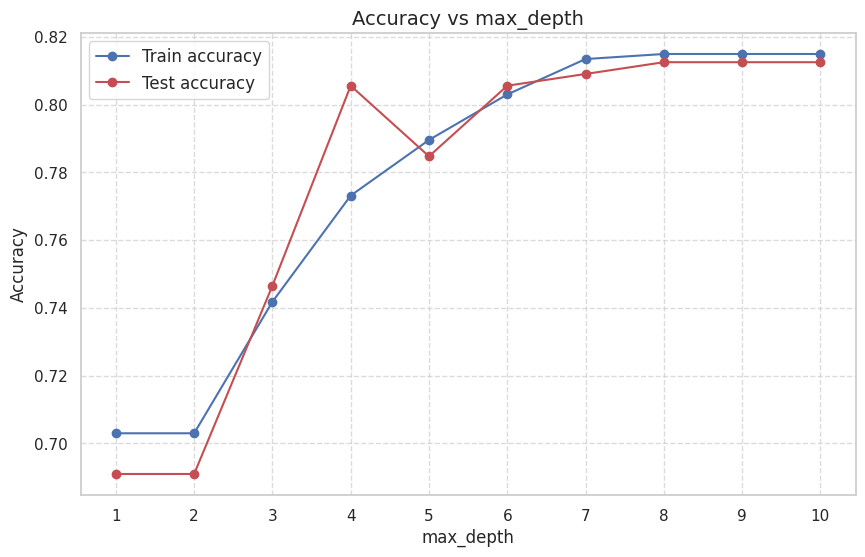

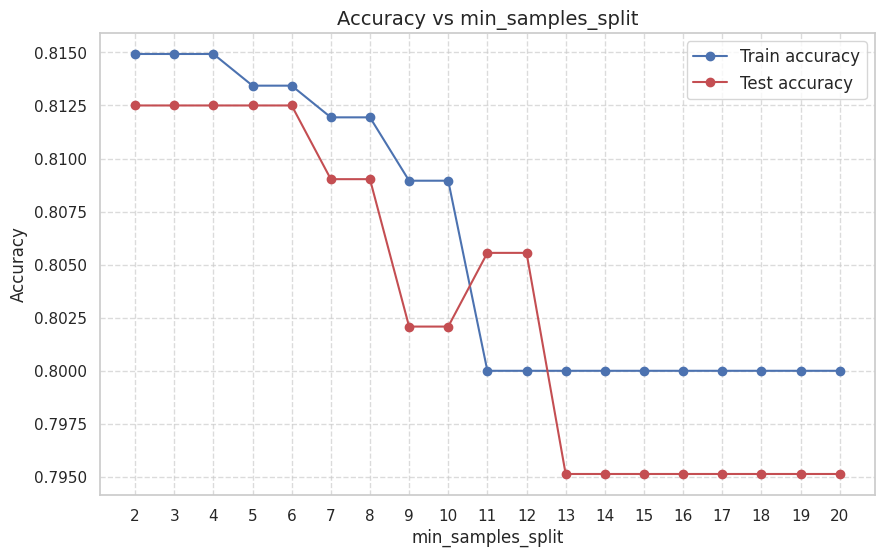

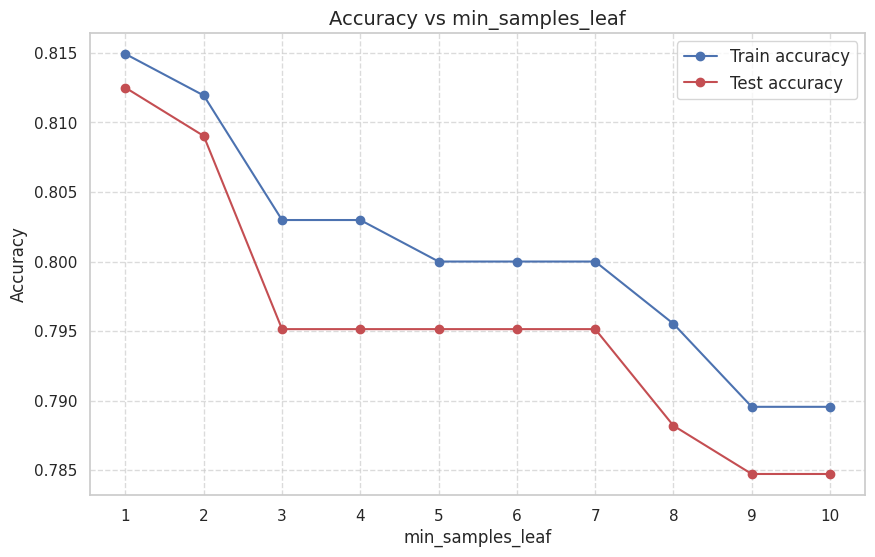

In [293]:
tic_tac_toe = pd.read_csv('tic-tac-toe-endgame.csv')
X = tic_tac_toe.drop('V10', axis=1).apply(LabelEncoder().fit_transform).values
y = (tic_tac_toe['V10'] == 'positive').astype(int).values

feature_types = ['categorical'] * X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def evaluate_param(name, values):
    train_scores = []
    test_scores = []

    for val in values:
        kwargs = {name: val}
        if name != 'max_depth':
            kwargs['max_depth'] = 10
        if name != 'min_samples_split':
            kwargs['min_samples_split'] = 2
        if name != 'min_samples_leaf':
            kwargs['min_samples_leaf'] = 1

        tree = DecisionTree(feature_types=feature_types, **kwargs)
        tree.fit(X_train, y_train)

        y_train_pred = tree.predict(X_train)
        y_test_pred = tree.predict(X_test)

        train_scores.append(accuracy_score(y_train, y_train_pred))
        test_scores.append(accuracy_score(y_test, y_test_pred))

    plt.figure(figsize=(10, 6))
    plt.plot(values, train_scores, 'b-', label='Train accuracy', marker='o')
    plt.plot(values, test_scores, 'r-', label='Test accuracy', marker='o')
    plt.title(f'Accuracy vs {name}', fontsize=14)
    plt.xlabel(name, fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(values)
    plt.show()

evaluate_param('max_depth', range(1, 11))
evaluate_param('min_samples_split', range(2, 21))
evaluate_param('min_samples_leaf', range(1, 11))

__Задание 9. (2 балла)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names):
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце)
* [tic-tac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце, датасет лежит на гитхабе вместе с заданием)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc — это класс 0, good, vgood — класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend — класс 0, very_recom, priority, spec_prior — класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам — наборы данных, по столбцам — алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [322]:
class DecisionTreeReal:
    def fit(self, X, y):
        self.model = DecisionTree(['real'] * X.shape[1])
        self.model.fit(X.values.astype(float) if hasattr(X, 'values') else X,
                      y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        return self.model.predict(X.values.astype(float) if hasattr(X, 'values') else X)

    def get_params(self, deep=True):
        return {}


class DecisionTreeCategorical:
    def fit(self, X, y):
        self.model = DecisionTree(['categorical'] * X.shape[1])
        self.model.fit(X.values if hasattr(X, 'values') else X,
                     y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        return self.model.predict(X.values if hasattr(X, 'values') else X)

    def get_params(self, deep=True):
        return {}


class DecisionTreeOneHot:
    def __init__(self):
        self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    def fit(self, X, y):
        X_data = X.values if hasattr(X, 'values') else X
        self.encoder.fit(X_data)
        X_encoded = self.encoder.transform(X_data)
        self.model = DecisionTree(['real'] * X_encoded.shape[1])
        self.model.fit(X_encoded, y.values if hasattr(y, 'values') else y)
        return self

    def predict(self, X):
        X_data = X.values if hasattr(X, 'values') else X
        return self.model.predict(self.encoder.transform(X_data))

    def get_params(self, deep=True):
        return {}

mushrooms = pd.read_csv('agaricus-lepiota.data', header=None)
tic_tac_toe = pd.read_csv('tic-tac-toe-endgame.csv')
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', header=None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data', header=None)

tic_tac_toe_target = tic_tac_toe.columns[-1]
cars_target = cars.columns[-1]
nursery_target = nursery.columns[-1]

target_mapping = {
    'mushrooms': {0: {'p': 0, 'e': 1}},
    'tic_tac_toe': {tic_tac_toe_target: {'negative': 0, 'positive': 1}},
    'cars': {cars_target: {'unacc': 0, 'acc': 0, 'good': 1, 'vgood': 1}},
    'nursery': {nursery_target: {
        'not_recom': 0, 'recommend': 0, 'very_recom': 1, 'priority': 1, 'spec_prior': 1}}
}

mushrooms[0] = mushrooms[0].map(target_mapping['mushrooms'][0])
tic_tac_toe[tic_tac_toe_target] = tic_tac_toe[tic_tac_toe_target].map(
    target_mapping['tic_tac_toe'][tic_tac_toe_target])
cars[cars_target] = cars[cars_target].map(target_mapping['cars'][cars_target])
nursery[nursery_target] = nursery[nursery_target].map(target_mapping['nursery'][nursery_target])

datasets = {
    'mushrooms': (mushrooms, 0),
    'tic_tac_toe': (tic_tac_toe, tic_tac_toe_target),
    'cars': (cars, -1),
    'nursery': (nursery, -1)
}

encoder = LabelEncoder()

for dataset_name, (data, target_col) in datasets.items():
    feature_cols = [col for col in data.columns if col != target_col]
    for col in feature_cols:
        data[col] = encoder.fit_transform(data[col].astype(str))

models = [
    ('Real', DecisionTreeReal()),
    ('Categorical', DecisionTreeCategorical()),
    ('OneHot', DecisionTreeOneHot()),
    ('Classifier', DecisionTreeClassifier())
]

results_df = pd.DataFrame(columns=['Dataset'] + [name for name, _ in models])

for name, (df, target) in datasets.items():
    if isinstance(target, int) and target < 0:
        X = df.iloc[:, :target]
        y = df.iloc[:, target]
    else:
        X = df.drop(columns=target)
        y = df[target]

    dataset_results = {'Dataset': name}

    for model_name, model in models:
        try:
            scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
            dataset_results[model_name] = scores.mean()
        except Exception as e:
            dataset_results[model_name] = f"Error: {str(e)}"

    results_df = pd.concat([results_df, pd.DataFrame([dataset_results])], ignore_index=True)

results_df = results_df.set_index('Dataset')
pd.options.display.float_format = '{:.4f}'.format

print("Результаты сравнения моделей:")
print(results_df)

Результаты сравнения моделей:
              Real  Categorical  OneHot  Classifier
Dataset                                            
mushrooms   0.2152       0.9963  0.4328      0.9567
tic_tac_toe 0.2427       0.5563  0.6973      0.7706
cars        0.9223       0.9635  0.9223      0.9433
nursery     0.9998       0.9998  0.9998      0.9997


__Задание 10. (1 балла)__

Проанализируйте результаты эксперимента.
Одинаково ли для разных наборов данных ранжируются алгоритмы?
Порассуждайте, почему так происходит.

Обратите внимание на значение признаков в разных наборах данных.
Присутствует ли в результатах какая-то компонента случайности?
Можно ли повлиять на нее и улушить работу алгоритмов?

**Ответ:**

Для разных наборов данных по разному ранжируются алгоритмы. Это говорит о том, что ранжирование алгоритмов существенно зависит от природы данных.

Результаты действительно содержат компоненту случайности, связанную с особенностями обработки признаков, и могут быть улучшены через более осмысленное кодирование категориальных переменных, настройку глубины дерева и размера узлов.

Вставьте что угодно, описывающее ваши впечатления от этого задания:

In [5]:
from cats_tree import CAT_TREE

print(CAT_TREE)


       /\_/\  
      ( o.o )  
       > ^ <  
      /     \  
  /\_/\     /\_/\  
 ( ^.^ )   ( -.- )  
  < . >     > _ <  
 /     \   /     \  
/\_/\
(=.=) 
< I >  

